# Interconnect predicción de abandono de clientes

## Contenido

* [Introducción](#intro)  
* [1. Descripción y preparación de los datos](#data_review)
    * [1.1. Importación de librerías y datos](#importation)
    * [1.2. Descripción inicial de los datos](#decription)
    * [1.3. Preparación inicial de los datos](#pre-process-1)
* [2. Análisis exploratorio de los datos](#data_analysis)
* [3. Preparación de los datos para los modelos](#data_preprocessing)    
* [4. Entrenamiento del modelo predictivo](#model_prediction)   
* [5. Predicciones en el conjunto de prueba](#predict_test)   
* [Conclusiones](#end)

## Introducción <a id="intro"></a>

Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. El equipo de marketing de Interconnect ha recopilado algunos de los datos personales de sus clientes, incluyendo información sobre sus planes y contratos.

### Servicios de Interconnect

Interconnect proporciona principalmente dos tipos de servicios:

1. Comunicación por teléfono fijo. El teléfono se puede conectar a varias líneas de manera simultánea.
2. Internet. La red se puede configurar a través de una línea telefónica (DSL, *línea de abonado digital*) o a través de un cable de fibra óptica.

Algunos otros servicios que ofrece la empresa incluyen:

- Seguridad en Internet: software antivirus (*ProtecciónDeDispositivo*) y un bloqueador de sitios web maliciosos (*SeguridadEnLínea*).
- Una línea de soporte técnico (*SoporteTécnico*).
- Almacenamiento de archivos en la nube y backup de datos (*BackupOnline*).
- Streaming de TV (*StreamingTV*) y directorio de películas (*StreamingPelículas*)

La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción.

### Descripción de los datos

Los datos consisten en archivos obtenidos de diferentes fuentes:

- `contract.csv` — información del contrato;
- `personal.csv` — datos personales del cliente;
- `internet.csv` — información sobre los servicios de Internet;
- `phone.csv` — información sobre los servicios telefónicos.

En cada archivo, la columna `customerID` (ID de cliente) contiene un código único asignado a cada cliente.

Característica objetivo: la columna `'EndDate'` es igual a `'No'`.  
Métrica principal: AUC-ROC.  
Métrica adicional: exactitud.  
Criterios de aceptabilidad: AUC-ROC ≥ 0.88 

### Plan aproximado del proyecto

**1. Descripción y preparación de los datos:** se leerá la información de las tablas y se determinará la calidad de los datos, se solucionarán problemas con nulos, duplicados y tipado de los datos.
    
**2. Análisis exploratorio de los datos:** se preparará un análisis descriptivo de las variables más interesantes, preparando hipótesis de los datos, con un enfoque en la pérdida de clientes y el balance de la variable objetiva.

**3. Preparación de los datos para los modelos:** se seleccionarán las características y se propondrán los modelos más atractivos para la tarea de clasificación, se prepararán los datos para que funcionen como entrada de los diferentes modelos, además de desglosarlos en 3 subconjuntos; entrenamiento, validación y prueba.
    
**4. Entrenamiento del modelo predictivo:** se estudiará el rendimiento de los modelos en el conjunto de validación con diferentes métricas; exactitud, recall, F1, F2 y AUC-ROC. También se usará la validación cruzada para dar robustez al estudio y se tendrá en cuenta si existe sobre ajuste en los modelos seleccionados.
   
**5. Predicciones en el conjunto de prueba:** con las conclusiones obtenidas en los entrenamientos del punto anterior, se pondrán a prueba los modelos para realizar una evaluación final que retorne conclusiones, recomendaciones y resultados para un modelo predictivo de la pérdida de clientes.

## 1. Descripción y preparación de los datos <a id="data_review"></a>

### 1.1. Importación de librerías y datos. <a id="importation"></a>

In [47]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
# Leemos los datos de información de contratos
df_contract = pd.read_csv('../files/datasets/input/final_provider/contract.csv')

In [3]:
# Leemos los datos personales de clientes
df_personal = pd.read_csv('../files/datasets/input/final_provider/personal.csv')

In [4]:
# Leemos los datos de los servicios de internet
df_internet = pd.read_csv('../files/datasets/input/final_provider/internet.csv')

In [5]:
# Leemos los datos de los servicios telefónicos
df_phone = pd.read_csv('../files/datasets/input/final_provider/phone.csv')

### 1.2. Descripción inicial de los datos. <a id="decription"></a>

#### Datos de contratos

In [6]:
# Información y estadísticas descriptivas de los contratos
print(df_contract.info())
print('---'*20)
print(df_contract.describe())
print('---'*20)
print(df_contract.describe(include='object'))
df_contract.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
------------------------------------------------------------
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000
------------------------------------------------------------
        customerID   BeginDate EndDate       

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15


Según la descripción y estadísticas de los datos de contratos (`df_contract`), podemos observar lo siguiente:
- No hay presencia de nulos en ninguna columna o fila.
- Existen 7043 entradas únicas en customerID, es decir, no hay contratos repetidos.
- Evidenciamos necesidades de cambios en el tipo de dato de las columnas BeginDate(cambiar a datetime), EndDate(cambiar a datetime), PaperlessBilling(cambiar a int 0/1), TotalCharges(cambiar a float).
- Se requiere separar la columna EndDate en dos, la primera que almacene las fechas de terminación en formato datetime y la segunda que almacene la variable objetivo, si un cliente ha abandonado o no en formato int (IsChurn).
- No hay incoherencias en los rangos numéricos de MonthlyCharges.
- Identificamos 3 tipos de entradas en la columna Type y 4 en PaymentMethod que validaremos. 

In [7]:
# Validación de entradas únicas en columnas clave
print(df_contract['Type'].unique())
print(df_contract['PaymentMethod'].unique())

['Month-to-month' 'One year' 'Two year']
['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


Los valores de las columnas categoricas principales no muestran entradas corrompidas o incoherentes.

#### Datos personales

In [8]:
# Información y estadísticas descriptivas de datos personales
print(df_personal.info())
print('---'*20)
print(df_personal.describe())
print('---'*20)
print(df_personal.describe(include='object'))
df_personal.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
------------------------------------------------------------
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
------------------------------------------------------------
        customerID gender Partner Dependents
count         7043   7043    7043       7043
unique        7043      2       2          2
top     3186-AJIEK   Male      No         No
freq             1   3555    3641       4933


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No


Según la descripción y estadísticas de los datos personales (`df_personal`), podemos observar lo siguiente:
- No hay presencia de nulos en ninguna columna o fila.
- Existen 7043 entradas únicas en customerID, es decir, no hay usuarios repetidos.
- Evidenciamos necesidades de cambios en el tipo de dato de las columnas Partner(cambiar a int 0/1) y Dependents(cambiar a int 0/1).
- No hay incoherencias en los rangos numéricos de SeniorCitizen.
- Identificamos 2 tipos de entradas en la columna gender (Female y Male).

In [9]:
# Validación de entradas únicas en columnas clave
print(df_personal['gender'].unique())
print(df_personal['SeniorCitizen'].unique())

['Female' 'Male']
[0 1]


Los valores de las columnas categoricas principales no muestran entradas corrompidas o incoherentes.

#### Datos de internet

In [10]:
# Información y estadísticas descriptivas de datos de internet
print(df_internet.info())
print('---'*20)
print(df_internet.describe())
df_internet.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
------------------------------------------------------------
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     3186-AJIEK     Fiber optic             No           No   
freq             1            3096           3498         3088

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No


Según la descripción y estadísticas de los datos personales (`df_internet`), podemos observar lo siguiente:
- No hay presencia de nulos en ninguna columna o fila.
- Existen 5517 entradas únicas en customerID, es decir, no hay usuarios repetidos.
- Todas las columnas son categorías transferibles al tipo int 0/1.
- Existen 2 tipos de entradas en la columna InternetService (DSL y Fiber optic).

In [11]:
# Validación de entradas únicas en columnas clave
print(df_internet['InternetService'].unique())

['DSL' 'Fiber optic']


Los valores de la columnas categorica principal no muestra entradas corrompidas o incoherentes.

#### Datos telefónicos

In [12]:
# Información y estadísticas descriptivas de datos telefónicos
print(df_phone.info())
print('---'*20)
print(df_phone.describe())
df_phone.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
------------------------------------------------------------
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     3186-AJIEK            No
freq             1          3390


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No


Según la descripción y estadísticas de los datos personales (`df_phone`), podemos observar lo siguiente:
- No hay presencia de nulos en ninguna columna o fila.
- Existen 6361 entradas únicas en customerID, es decir, no hay usuarios repetidos.
- La columna MultipleLines es transferible al tipo int 0/1.

### 1.3. Preparación inicial de los datos. <a id="pre-process-1"></a>

En esta sección se ajustarán las observaciones realizadas en la sección anterior, para que los datos estén listos para el análisis exploratorio y la preparación de los datos para los modelos.

#### Datos de contratos

In [13]:
# Cambio de tipo de datos de la columna 'BeginDate' a datetime
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate']).dt.date

In [14]:
# Creación de la columna 'IsChurned'
df_contract['IsChurn'] = df_contract['EndDate'].map(lambda x: 1 if x != 'No' else 0)

# Cambio de tipo de datos de la columna 'EndDate' a datetime
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.date

In [15]:
# Conversión de columna categórica PaperlessBilling a numérica booleana
df_contract['PaperlessBilling'] = df_contract['PaperlessBilling'].map({'Yes': 1, 'No': 0})

In [16]:
# Revisión del contenido a profundidad de la columna TotalCharges
df_contract[df_contract['TotalCharges'].str.contains('[^\d.]')]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsChurn
488,4472-LVYGI,2020-02-01,NaT,Two year,1,Bank transfer (automatic),52.55,,0
753,3115-CZMZD,2020-02-01,NaT,Two year,0,Mailed check,20.25,,0
936,5709-LVOEQ,2020-02-01,NaT,Two year,0,Mailed check,80.85,,0
1082,4367-NUYAO,2020-02-01,NaT,Two year,0,Mailed check,25.75,,0
1340,1371-DWPAZ,2020-02-01,NaT,Two year,0,Credit card (automatic),56.05,,0
3331,7644-OMVMY,2020-02-01,NaT,Two year,0,Mailed check,19.85,,0
3826,3213-VVOLG,2020-02-01,NaT,Two year,0,Mailed check,25.35,,0
4380,2520-SGTTA,2020-02-01,NaT,Two year,0,Mailed check,20.00,,0
5218,2923-ARZLG,2020-02-01,NaT,One year,1,Mailed check,19.70,,0
6670,4075-WKNIU,2020-02-01,NaT,Two year,0,Mailed check,73.35,,0


Algunos valores no son numéricos en la columna TotalCharges, todos corresponden a la fecha de ingreso '2020-02-01', por lo que están relacionados con ingresos recientes que aún no registran valores, por lo que se procederá a convertirlos a 0.0.

In [17]:
# Reemplazo de valores no numéricos en 'TotalCharges' por 0.0
df_contract.loc[df_contract['TotalCharges'].str.contains('[^\d.]'), 'TotalCharges'] = 0.0

# Conversión de la columna 'TotalCharges' a tipo numérico
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'])
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsChurn
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1


#### Datos personales

In [18]:
# Conversión de columna categórica Partner a numérica booleana
df_personal['Partner'] = df_personal['Partner'].map({'Yes': 1, 'No': 0})

In [19]:
# Conversión de columna categórica Dependents a numérica booleana
df_personal['Dependents'] = df_personal['Dependents'].map({'Yes': 1, 'No': 0})
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,1,0
1,5575-GNVDE,Male,0,0,0
2,3668-QPYBK,Male,0,0,0
3,7795-CFOCW,Male,0,0,0
4,9237-HQITU,Female,0,0,0


#### Datos de internet

In [20]:
# Conversión de columnas categóricas a numéricas booleana
for col in df_internet.columns.drop(['customerID', 'InternetService']):
    df_internet[col] = df_internet[col].map({'Yes': 1, 'No': 0})

df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,0,1,0,0,0,0
1,5575-GNVDE,DSL,1,0,1,0,0,0
2,3668-QPYBK,DSL,1,1,0,0,0,0
3,7795-CFOCW,DSL,1,0,1,1,0,0
4,9237-HQITU,Fiber optic,0,0,0,0,0,0


#### Datos telefónicos

In [21]:
# Conversión de columna categórica MultipleLines a numérica booleana
df_phone['MultipleLines'] = df_phone['MultipleLines'].map({'Yes': 1, 'No': 0})
df_phone.head()


,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1


## 2. Análisis exploratorio de los datos <a id='data_analysis'></a>

En esta sección ...

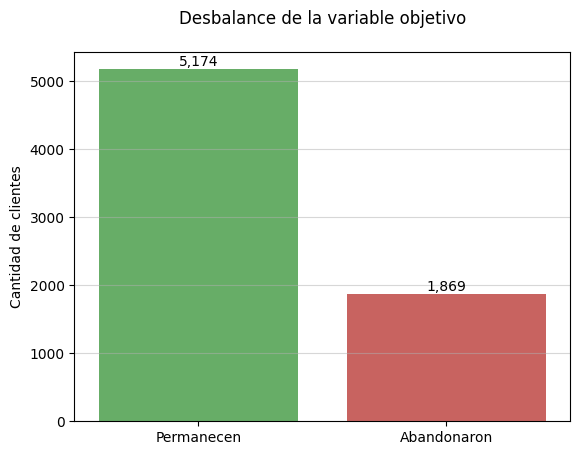

In [184]:
# Conteo de valores en la columna IsChurn
churn_counts = df_contract['IsChurn'].value_counts().sort_index() 

# Definir colores personalizados en el mismo orden que las barras (0: No Churn, 1: Churn)
custom_colors = ['#5CB85C', '#D9534F']

# Visualización de la distribución de la variable IsChurn
ax = sns.barplot(x=churn_counts.index.astype(str), y=churn_counts.values, hue=churn_counts.index.astype(str), palette=custom_colors)

# Etiquetas y título
for i, value in enumerate(churn_counts.values):
    ax.text(i, value + max(churn_counts.values) * 0.001, f'{value:,}', ha='center', va='bottom')

plt.xlabel('')
plt.ylabel('Cantidad de clientes')
plt.title('Desbalance de la variable objetivo', pad=20)
plt.xticks([0, 1], ['Permanecen', 'Abandonaron'])
plt.grid(axis='y', alpha=0.5)
plt.show()

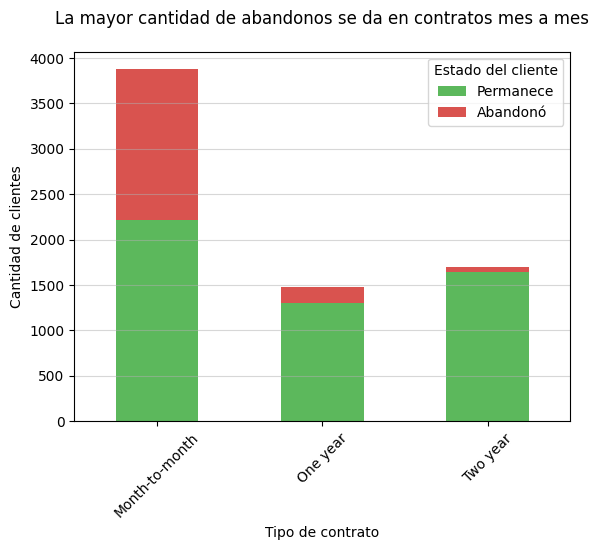

In [124]:
# Agrupar datos por tipo de contrato y churn, y organizarlos
type_vs_churn = df_contract.groupby('Type')['IsChurn'].value_counts().unstack()

# Visualización de la distribución del tipo de contrato en funcion del abandono
type_vs_churn.plot(kind='bar', stacked=True, color=custom_colors)

# Etiquetas y título
plt.xlabel('Tipo de contrato')
plt.ylabel('Cantidad de clientes')
plt.title('La mayor cantidad de abandonos se da en contratos mes a mes', pad=20)
plt.legend(title='Estado del cliente', labels=['Permanece', 'Abandonó']) 
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.5)
plt.show()

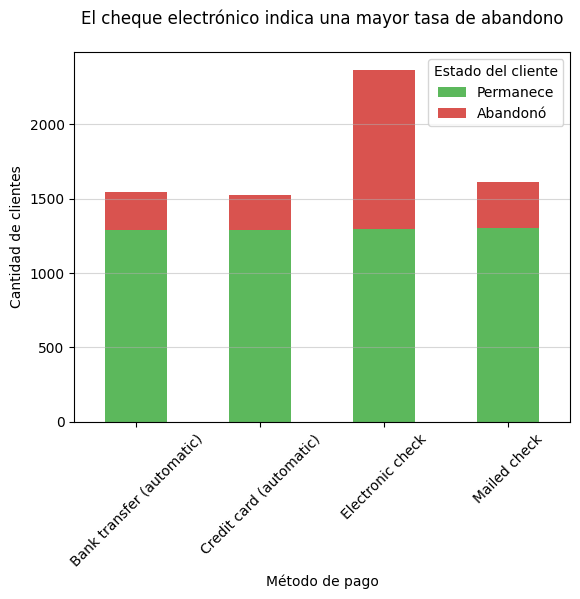

In [ ]:
# Agrupar datos por método de pago y churn, y organizarlos
payment_vs_churn = df_contract.groupby('PaymentMethod')['IsChurn'].value_counts().unstack()

# Visualización de la distribución de la variable PaymentMethod en funcion del abandono
payment_vs_churn.plot(kind='bar', stacked=True, color=custom_colors)

# Etiquetas y título
plt.xlabel('Método de pago')
plt.ylabel('Cantidad de clientes')
plt.title('El cheque electrónico indica una mayor tasa de abandono', pad=20)
plt.legend(title='Estado del cliente', labels=['Permanece', 'Abandonó']) 
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.5)
plt.show()

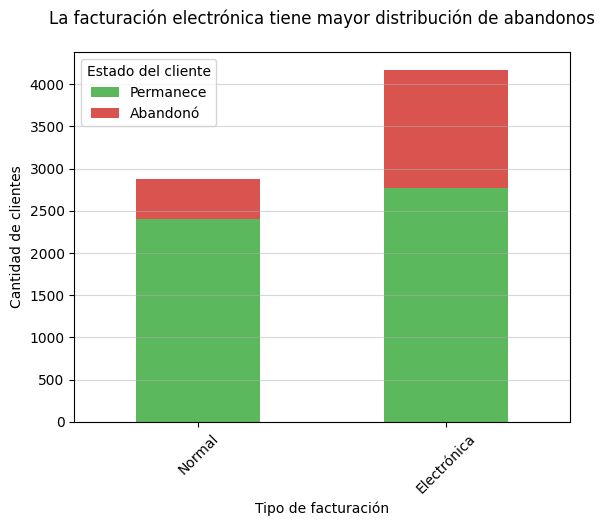

In [ ]:
# Agrupar datos por tipo de facturación y churn, y organizarlos
billing_vs_churn = df_contract.groupby('PaperlessBilling')['IsChurn'].value_counts().unstack()

# Visualización de la distribución de la variable PaperlessBilling en funcion del abandono
billing_vs_churn.plot(kind='bar', stacked=True, color=custom_colors)

# Etiquetas y título
plt.xlabel('Tipo de facturación')
plt.ylabel('Cantidad de clientes')
plt.title('La facturación electrónica tiene mayor distribución de abandonos', pad=20)
plt.legend(title='Estado del cliente', labels=['Permanece', 'Abandonó']) 
plt.xticks([0, 1], ['Normal', 'Electrónica'], rotation=45)
plt.grid(axis='y', alpha=0.5)
plt.show()

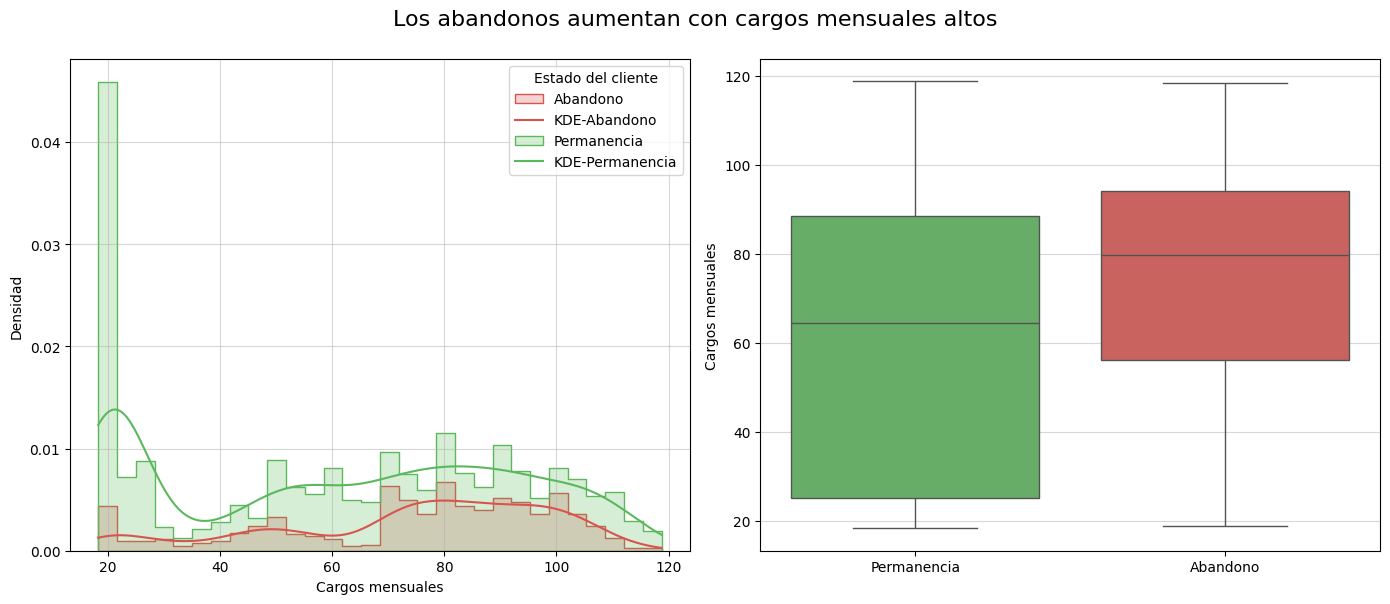

In [187]:
# Visualización de la distribución de los cargos mensuales en funcion del abandono
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histograma en el primer subplot
sns.histplot(
    data=df_contract, x='MonthlyCharges', hue='IsChurn', bins=30,
    kde=True, palette=custom_colors, ax=axes[0], element='step', stat='density', legend=True
)
axes[0].set_xlabel('Cargos mensuales')
axes[0].set_ylabel('Densidad')
axes[0].legend(title='Estado del cliente', labels=['Abandono', 'KDE-Abandono', 'Permanencia', 'KDE-Permanencia'])
axes[0].grid(axis='both', alpha=0.5)

# Boxplot en el segundo subplot
sns.boxplot(
    data=df_contract, x='IsChurn', y='MonthlyCharges', hue='IsChurn', palette=custom_colors, ax=axes[1], legend=False
)
axes[1].set_xlabel('')
axes[1].set_ylabel('Cargos mensuales')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Permanencia', 'Abandono'])

axes[1].grid(axis='y', alpha=0.5)

# Título
fig.suptitle('Los abandonos aumentan con cargos mensuales altos', fontsize=16, y=1)
plt.tight_layout()
plt.show()

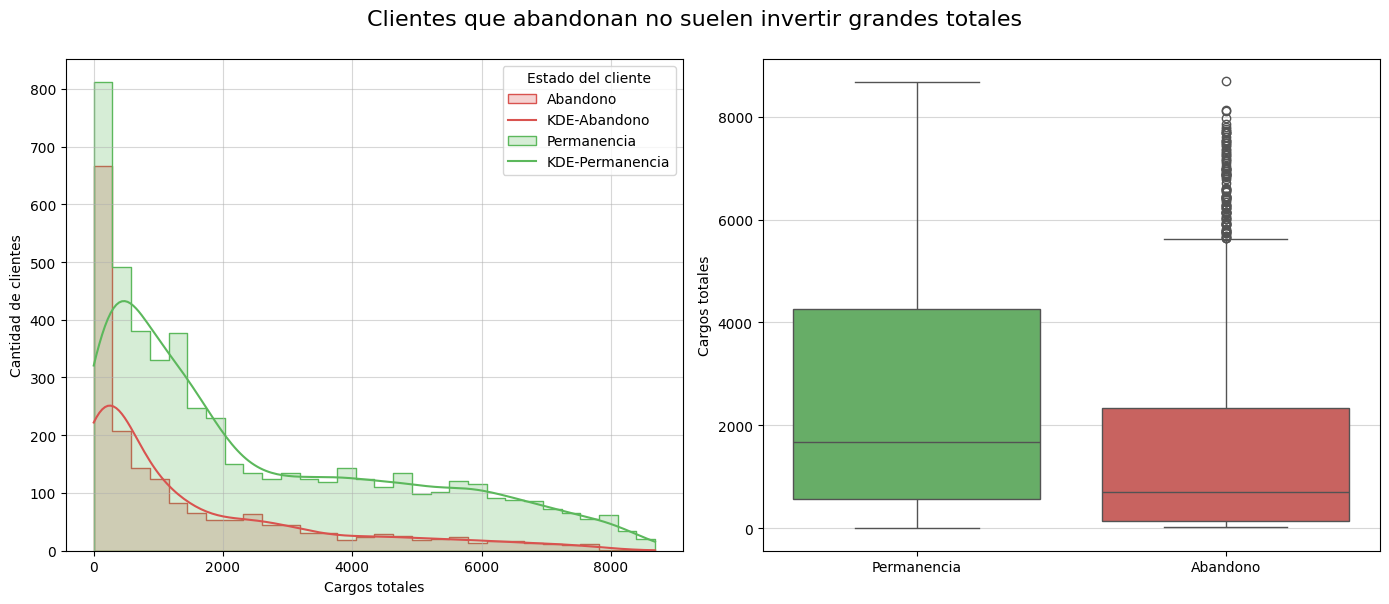

In [186]:
# Visualización de la distribución de los cargos totales en funcion del abandono
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histograma en el primer subplot
sns.histplot(
    data=df_contract, x='TotalCharges', hue='IsChurn', bins=30,
    kde=True, palette=custom_colors, ax=axes[0], element='step'
)
axes[0].set_xlabel('Cargos totales')
axes[0].set_ylabel('Cantidad de clientes')
axes[0].legend(title='Estado del cliente', labels=['Abandono', 'KDE-Abandono', 'Permanencia', 'KDE-Permanencia'])
axes[0].grid(axis='both', alpha=0.5)

# Boxplot en el segundo subplot
sns.boxplot(
    data=df_contract, x='IsChurn', y='TotalCharges', hue='IsChurn', palette=custom_colors, ax=axes[1], legend=False
)
axes[1].set_xlabel('')
axes[1].set_ylabel('Cargos totales')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Permanencia', 'Abandono'])

axes[1].grid(axis='y', alpha=0.5)

# Título
fig.suptitle('Clientes que abandonan no suelen invertir grandes totales', fontsize=16, y=1)
plt.tight_layout()
plt.show()

In [ ]:
# Calcula la duración en meses, manejando valores faltantes
def diff_months(row):
	if pd.notnull(row['EndDate']) and pd.notnull(row['BeginDate']):
		end = row['EndDate']
		begin = row['BeginDate']
		return (end.year - begin.year) * 12 + (end.month - begin.month)
	else:
		return np.nan

df_contract['DurationMonths'] = df_contract.apply(diff_months, axis=1)
df_contract['DurationMonths'].describe()

count    1869.000000
mean       17.979133
std        19.531123
min         1.000000
25%         2.000000
50%        10.000000
75%        29.000000
max        72.000000
Name: DurationMonths, dtype: float64

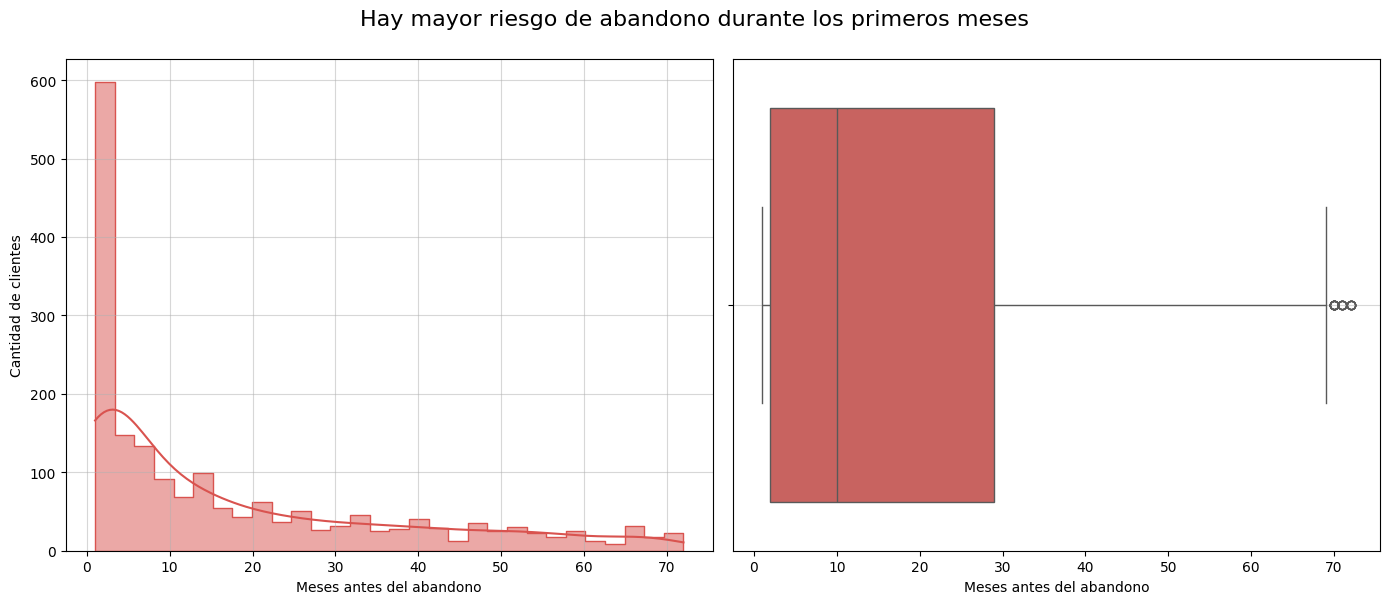

In [198]:
# Visualización de la distribución de los cargos totales en funcion del abandono
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Histograma en el primer subplot
sns.histplot(
    data=df_contract, x='DurationMonths', color=custom_colors[1], bins=30,
    kde=True, ax=axes[0], element='step', legend=True
)
axes[0].set_xlabel('Meses antes del abandono')
axes[0].set_ylabel('Cantidad de clientes')
axes[0].grid(axis='both', alpha=0.5)

# Boxplot en el segundo subplot
sns.boxplot(
    data=df_contract, x='DurationMonths', color=custom_colors[1], ax=axes[1], legend=False, orient='horizontal'
)
axes[1].set_ylabel('')
axes[1].set_xlabel('Meses antes del abandono')
axes[1].grid(axis='y', alpha=0.5)

# Título
fig.suptitle('Hay mayor riesgo de abandono durante los primeros meses', fontsize=16, y=1)
plt.tight_layout()
plt.show()

In [84]:
df_contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,IsChurn,DurationMonths
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,1,Electronic check,29.85,29.85,0,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,0,Mailed check,56.95,1889.50,0,NaN
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,1,Mailed check,53.85,108.15,1,2.0
3,7795-CFOCW,2016-05-01,NaT,One year,0,Bank transfer (automatic),42.30,1840.75,0,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,1,Electronic check,70.70,151.65,1,2.0
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,NaT,One year,1,Mailed check,84.80,1990.50,0,NaN
7039,2234-XADUH,2014-02-01,NaT,One year,1,Credit card (automatic),103.20,7362.90,0,NaN
7040,4801-JZAZL,2019-03-01,NaT,Month-to-month,1,Electronic check,29.60,346.45,0,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01,Month-to-month,1,Mailed check,74.40,306.60,1,4.0
